In [2]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
import numpy as np
from gymnasium.spaces import Box, Discrete

import matplotlib.pyplot as plt
from stable_baselines3 import DQN

In [3]:
import grid2op
print(grid2op.__version__)

1.10.5


In [4]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )

        ##########
        # REWARD #
        ##########
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.change_reward(cr)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        # Use the gym environment's observation and action spaces
        self.observation_space = self._gym_env.observation_space
        self.action_space = self._gym_env.action_space

    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self._gym_env.step(action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components

        return obs, reward, terminated, truncated, info

    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs


- #### `Initialise` the environment

In [48]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )

        # Set combined reward
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.change_reward(cr)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        sample_obs, _ = self._gym_env.reset()
        flat_obs = self.flatten_observation(sample_obs)
        obs_size = flat_obs.shape[0]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []
        num_powerlines =10
        num_generators = 6
        num_sub_stations = 16

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

        # # Action 1: Open line 0
        # open_line_0 = action_space({"set_line_status": [(0, -1)]})
        # gym_open_line_0 = self._gym_env.action_space.to_gym(open_line_0)
        # self.available_actions.append(gym_open_line_0)

        # # Action 2: Close line 0
        # close_line_0 = action_space({"set_line_status": [(0, 1)]})
        # gym_close_line_0 = self._gym_env.action_space.to_gym(close_line_0)
        # self.available_actions.append(gym_close_line_0)

        #Open and Close all powerlines
        # for line in range(num_powerlines):
        #     close_line = action_space({"set_line_status":[(line,-1)]})
        #     gym_close_line = self._gym_env.action_space.to_gym(close_line)
        #     open_line = action_space({"set_line_status":[(line,1)]})
        #     gym_open_line = self._gym_env.action_space.to_gym(open_line)
        #     self.available_actions.append(gym_close_line)
        #     self.available_actions.append(gym_open_line)
        
        # # Switch line status
        # for line in range(num_powerlines):
        #     switch_line = action_space({"switch_line_status":[line]})
        #     gym_switch_line = self._gym_env.action_space.to_gym(switch_line)
        #     self.available_actions.append(gym_switch_line)
        
        # Set all substation units BUSSES
        # for generator in range(num_sub_stations):
        #     set_gen_0 = action_space({"set_bus":[(generator,-1)]})
        #     gym_set_gen_0 = self._gym_env.action_space.to_gym(set_gen_0)
        #     set_gen_1 = action_space({"set_bus":[(generator,1)]})
        #     gym_set_gen_1 = self._gym_env.action_space.to_gym(set_gen_1)
        #     set_gen_2 = action_space({"set_bus":[(generator,2)]})
        #     gym_set_gen_2 = self._gym_env.action_space.to_gym(set_gen_2)
        #     self.available_actions.append(gym_set_gen_0)
        #     self.available_actions.append(gym_set_gen_1)
        #     self.available_actions.append(gym_set_gen_2)

        #Redispatch all generators
        # act.redispatch = np.ones(act.n_gen, dtype=float)
        for generator in range(num_generators):
            redispatch_gen = action_space({"redispatch":[(generator,2.5)]})
            gym_redispatch_gen = self._gym_env.action_space.to_gym(redispatch_gen)
            self.available_actions.append(gym_redispatch_gen)


        # Add more actions as needed
        # For example, open/close other lines
        # Valid keys are {'change_line_status', 'set_bus', 'set_storage', 'change_bus', 'raise_alert', 'raise_alarm', 'curtail', 'redispatch'}

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))

    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components

        return obs, reward, terminated, truncated, info

    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

- #### `Test` the environment

In [49]:
def test_environment():
    env = Gym2OpEnv()
    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Initial observation shape: (544,)
Initial observation: [ 1.00000000e+00  0.00000000e+00 -2.11220379e+01  2.10873070e+01
  1.68289093e+02  1.58752136e+02  9.16928101e+01  1.70073975e+02
  1.43915390e+02  8.48878174e+01  1.19380775e+02  3.69595032e+02
  2.55726273e+02  6.28994141e+02  1.05945435e+02  2.39337173e+02
  2.58574310e+02  6.92546844e+01  2.74917206e+02  1.21686877e+03
  4.15242249e+02  1.00283539e+03  1.08662537e+03  1.02236249e+03
  1.75360046e+02  1.58643250e+02  9.60379562e+01  1.69531082e+02
  1.43570389e+02  8.26553497e+01  1.19380775e+02  3.69595032e+02
  2.55726273e+02  6.28994141e+02  1.05945435e+02  2.39337173e+02
  2.58574310e+02  6.92546844e+01  2.74917206e+02  1.26227470e+02
  6.21052971e+01  1.55942566e+02  9.31393127e+02  7.15653748e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1

-  #### `Print` observation space and action space

In [50]:
def test_environment():
    env = Gym2OpEnv()

    # Print the action and observation spaces
    print("Action space:", env.action_space)
    print("Number of actions:", env.action_space.n)
    print("Observation space:", env.observation_space)
    print("Observation shape:", env.observation_space.shape)

    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    # Sample a random action
    action = env.action_space.sample()
    print("Sampled action index:", action)
    print("Corresponding action:", env.available_actions[action])

    # Take a step
    obs, reward, terminated, truncated, info = env.step(action)
    print("Observation after action:", obs)
    print("Reward received:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

In [51]:
test_environment()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Action space: Discrete(7)
Number of actions: 7
Observation space: Box(-inf, inf, (544,), float32)
Observation shape: (544,)
Initial observation shape: (544,)
Initial observation: [ 1.00000000e+00  0.00000000e+00 -2.11937943e+01  2.11230946e+01
  1.69826706e+02  1.59924454e+02  9.92585754e+01  1.70880966e+02
  1.44728882e+02  7.88026581e+01  1.19260353e+02  3.54330261e+02
  2.49803955e+02  6.12436707e+02  1.11307098e+02  2.41296204e+02
  2.46253143e+02  6.72096024e+01  2.67224884e+02  1.22056604e+03
  4.17728516e+02  1.02306641e+03  1.05696423e+03  1.02054681e+03
  1.76897903e+02  1.60010147e+02  1.03606552e+02  1.70575134e+02
  1.44570450e+02  7.63764725e+01  1.19260353e+02  3.54330261e+02
  2.49803955e+02  6.12436707e+02  1.11307098e+02  2.41296204e+02
  2.46253143e+02  6.72096024e+01  2.67224884e+02  1.26610977e+02
  6.24771576e+01  1.59088501e+02  9.05969421e+02  7.14382751e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000

- #### `Test` the environment

In [52]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


#####################
# OBSERVATION SPACE #
#####################
Box(-inf, inf, (544,), float32)
#####################

#####################
#   ACTION SPACE    #
#####################
Discrete(7)
#####################


step = 0 (reset):
	 obs = [ 1.00000000e+00  0.00000000e+00 -2.11367340e+01  2.10946407e+01
  1.61748123e+02  1.36520874e+02  1.05465363e+02  1.47378555e+02
  1.17845955e+02  5.60593834e+01  1.31729965e+02  4.12662720e+02
  2.54527298e+02  6.45125061e+02  1.15475140e+01  2.00558990e+02
  2.99972260e+02  7.62247772e+01  3.08082611e+02  1.03934631e+03
  3.44055237e+02  6.23550720e+02  1.04596033e+03  8.72223938e+02
  1.68817993e+02  1.36863037e+02  1.09815178e+02  1.47118744e+02
  1.17709801e+02  5.22852440e+01  1.31729965e+02  4.12662720e+02
  2.54527298e+02  6.45125061e+02  1.15475140e+01  2.00558990e+02
  2.99972260e+02  7.62247772e+01  3.08082611e+02  1.07812805e+02
  5.14582825e+01  9.69631577e+01  8.96537415e+02  6.10556702e+02
  0.00000000e+00  0.00000000e+00  0.

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92e+03 |
|    ep_rew_mean      | 645      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 201      |
|    time_elapsed     | 38       |
|    total_timesteps  | 7699     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.232    |
|    n_updates        | 1899     |
----------------------------------


c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and

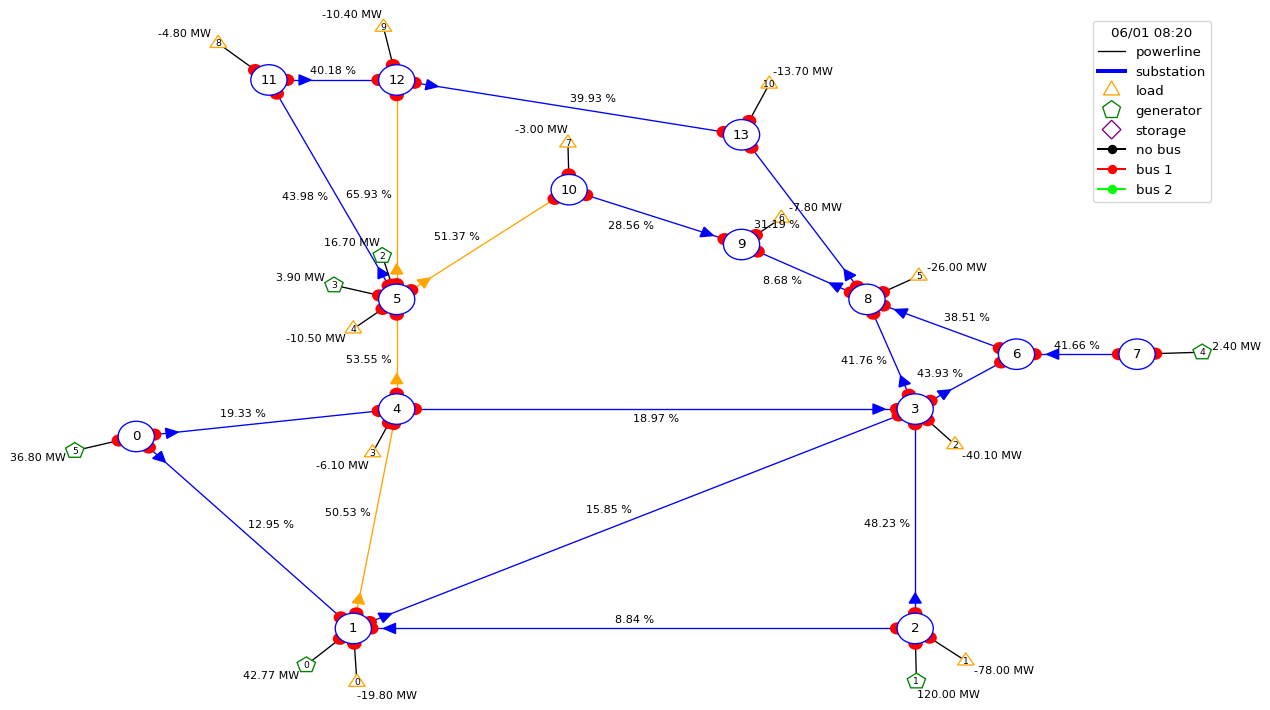

In [53]:
def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()

- #### `Evaluate` the environment

In [54]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_sum  =0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        reward_sum+=total_reward
    print(f"Average Reward:",reward_sum/num_episodes)
    return episode_rewards

- #### `Run` the evaluation function

In [55]:
if __name__ == "__main__":
    # Initialize the environment and model
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    
    # Train the model
    #model.learn(total_timesteps=10000)
    #model.save("dqn_grid2op_agent")
    
    # Load the trained model (optional)
    model = DQN.load("dqn_grid2op_agent", env=env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 200
    rewards = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward = 1128.9835803806782
Episode 2: Total Reward = 472.78018639981747
Episode 3: Total Reward = 1571.1956078410149
Episode 4: Total Reward = 372.12797160446644
Episode 5: Total Reward = 477.2860688716173
Episode 6: Total Reward = 470.94974359869957
Episode 7: Total Reward = 1128.4642698317766
Episode 8: Total Reward = 932.487508893013
Episode 9: Total Reward = 175.62723070383072
Episode 10: Total Reward = 278.71131044626236
Episode 11: Total Reward = 381.70242846012115
Episode 12: Total Reward = 182.83537958562374
Episode 13: Total Reward = 1747.4120522737503
Episode 14: Total Reward = 173.0455219745636
Episode 15: Total Reward = 978.6347483843565
Episode 16: Total Reward = 273.9148239046335
Episode 17: Total Reward = 557.4246736317873
Episode 18: Total Reward = 333.92044447362423
Episode 19: Total

- #### `Visualise` the results

In [56]:
def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


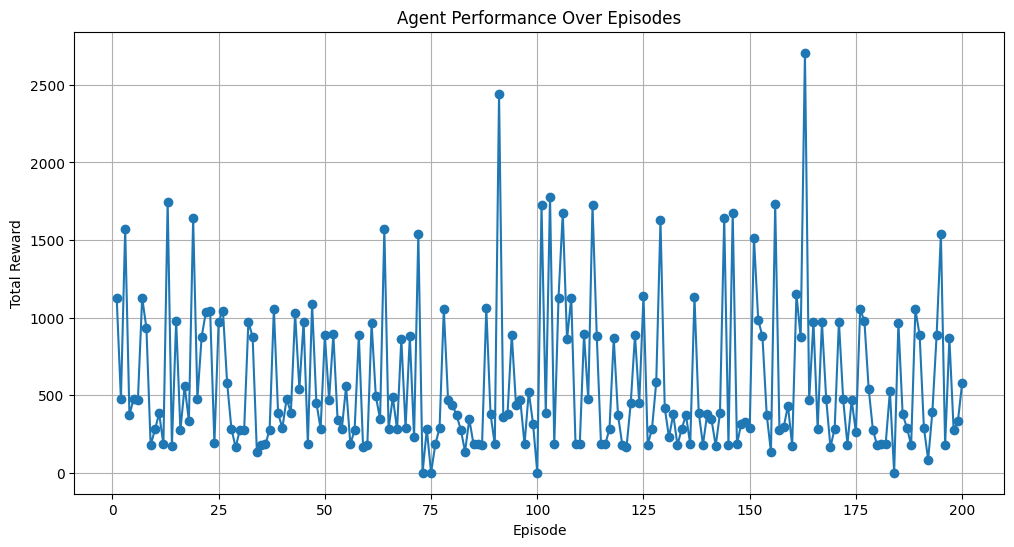

In [57]:
# call plot function
plot_rewards(rewards)

- #### `Extracting` individual reward components (L2RPN & N1)

In [86]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_components_list = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        episode_reward_components = {'L2RPN': 0.0, 'N1': 0.0}
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
            # Accumulate reward components
            reward_components = info.get('reward_components', {})
            for key in episode_reward_components.keys():
                episode_reward_components[key] += reward_components.get(key, 0.0)
        episode_rewards.append(total_reward)
        reward_components_list.append(episode_reward_components)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        print(f"Reward Components: {episode_reward_components}")
        
    return episode_rewards, reward_components_list

In [87]:
# Call the Evaluate agent function
rewards, reward_components_list = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

Episode 1: Total Reward = 131.29422691464424
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 2: Total Reward = 176.23326900601387
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 3: Total Reward = 138.77094942331314
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 4: Total Reward = 220.7371575832367
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 5: Total Reward = 131.20245963335037
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 6: Total Reward = 133.86926700174809
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 7: Total Reward = 84.39300580322742
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 8: Total Reward = 51.943852841854095
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 9: Total Reward = 179.30641283094883
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 10: Total Reward = 49.146308213472366
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 11: Total Reward = 224.53727869689465
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 12

KeyboardInterrupt: 

- #### `Visualising` individual reward components (L2RPN & N1)

In [38]:
def plot_reward_components(reward_components_list):
    episodes = range(1, len(reward_components_list) + 1)
    l2rpn_rewards = [rc['L2RPN'] for rc in reward_components_list]
    n1_rewards = [rc['N1'] for rc in reward_components_list]
    
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, l2rpn_rewards, label='L2RPN Reward', marker='o')
    plt.plot(episodes, n1_rewards, label='N1 Reward', marker='s')
    plt.title('Reward Components Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

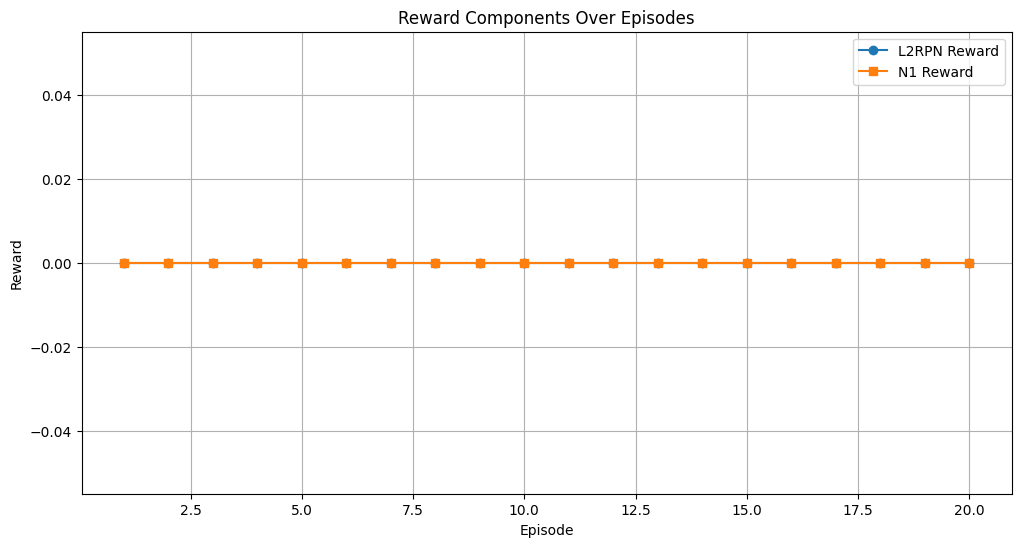

In [39]:
# Call the plot_reward_components
plot_reward_components(reward_components_list)